In [1]:
import numpy as np
import copy
from IPython.display import HTML
import matplotlib.pyplot as plt
import dill

import SimPEG as simpeg
from SimPEG.EM import NSEM

import sys
from pymatsolver import PardisoSolver
import telluricpy

# Set some matplotlib settings
%matplotlib notebook


In [2]:
# Define the area of interest
bw, be = -250., 250
bs, bn = -250., 250.
bb, bt = -500.,0.

In [3]:
## Comment:
# Decreased the cell sizes to 


#Cell size
csx, csy, csz = 10., 10.,5
# Number of core cells in each directiPon s
ncx, ncy, ncz = 30,3,7.
# Number of padding cells to add in each direction
npad = 13
nzpad = 14
growrate = 1.5
# Vectors of cell lengthts in each direction
hx = [(csx,npad, -growrate),(csx,ncx),(csx,npad,growrate)]
hy = [(csy,npad, -growrate),(csy,ncy),(csy,npad, growrate)]
hz = [(csz,nzpad,-growrate),(csz,ncz),(csz,nzpad, growrate)]
#hz = [(csz,npad, -1.5),(csz,ncz),(csz,npad,1.5)]

# nrCcore = [6, 5, 4, 2, 2, 2, 2]
airPad = simpeg.Utils.meshTensor([(csz,nzpad,growrate)])
# vCore = np.concatenate([ np.ones(i)*s for i, s in zip(nrCcore,(simpeg.Utils.meshTensor([(csz,1),(csz,5,1.3)])))])[::-1]
# botPad = simpeg.Utils.meshTensor([(vCore[0],2,-1.5)])
# hz = np.concatenate((botPad,vCore,airPad))

# Create mesh
mesh = simpeg.Mesh.TensorMesh([hx, hy, hz],x0="CCN")

In [33]:
dill.dump(mesh,open('mesh_quartSpace.pkl','w'))
np.save('sigma_quartSpace',sigma)

In [4]:
print np.sum(simpeg.Utils.meshTensor([(csx,npad,growrate)]))
print np.sum(airPad)
print mesh.x0

5808.58520508
4363.93890381
[-5958.58520508 -5823.58520508 -8762.87780762]


In [5]:
# Map mesh coordinates from local to UTM coordiantes
mesh.x0[2] = mesh.x0[2]+np.sum(airPad) + 10
#mesh.x0[2] = mesh.x0[2]- csz/2.#-np.max(mesh.vectorCCz[npad:-npad]) 

# mesh.plotSlice(np.ones(mesh.nC)*np.nan, grid=True)
# mesh.plotSlice(np.ones(mesh.nC)*np.nan, grid=True, normal="Y")
# mesh.plotGrid()
# plt.gca().set_aspect('equal')
# plt.show()

print mesh.x0
print mesh.nC
print mesh.nF

[-5958.58520508 -5823.58520508 -4388.93890381]
56840
175119


In [6]:
mesh.vectorNx

array([-5958.58520508, -4012.39013672, -2714.92675781, -1849.95117188,
       -1273.30078125,  -888.8671875 ,  -632.578125  ,  -461.71875   ,
        -347.8125    ,  -271.875     ,  -221.25      ,  -187.5       ,
        -165.        ,  -150.        ,  -140.        ,  -130.        ,
        -120.        ,  -110.        ,  -100.        ,   -90.        ,
         -80.        ,   -70.        ,   -60.        ,   -50.        ,
         -40.        ,   -30.        ,   -20.        ,   -10.        ,
           0.        ,    10.        ,    20.        ,    30.        ,
          40.        ,    50.        ,    60.        ,    70.        ,
          80.        ,    90.        ,   100.        ,   110.        ,
         120.        ,   130.        ,   140.        ,   150.        ,
         165.        ,   187.5       ,   221.25      ,   271.875     ,
         347.8125    ,   461.71875   ,   632.578125  ,   888.8671875 ,
        1273.30078125,  1849.95117188,  2714.92675781,  4012.39013672,
      

In [7]:
sig_air = 1e-8
sig_east = 1e-1
sig_west = 1e-2
sigma = sig_east*np.ones(mesh.nC)

#West
west = mesh.gridCC[:,0]<0
sigma[west] = sig_west

#air cells
air = mesh.gridCC[:,2]>0.
sigma[air]=sig_air

# Get a 1D background model
bgsigma = mesh.r(sigma,'CC','CC','M')[0,0,:]

<IPython.core.display.Javascript object>


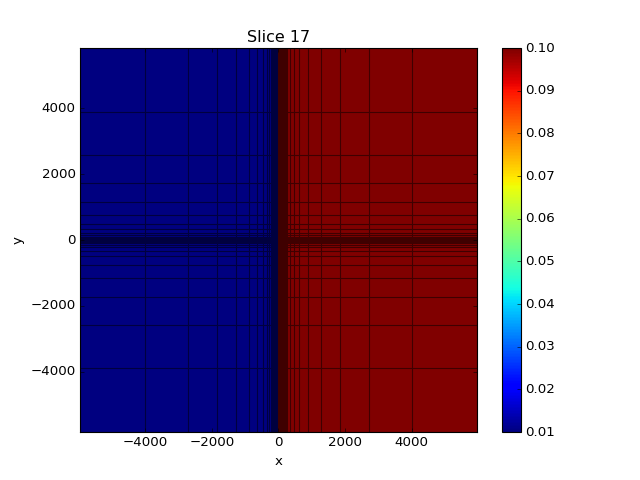

In [8]:
a = mesh.plotSlice(sigma, grid=True, normal="Z")
#plt.gca().set_xlim([-250.,250])
#plt.gca().set_ylim([-500.,10.])
plt.colorbar(a[0])

<IPython.core.display.Javascript object>


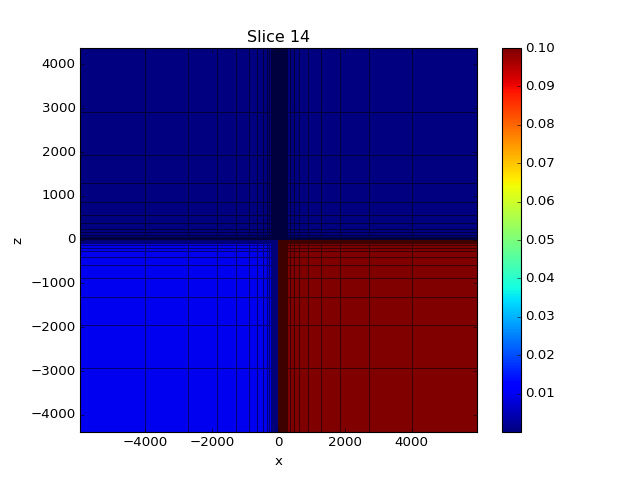

In [9]:
a = mesh.plotSlice(sigma, grid=True, normal="Y")
#plt.gca().set_xlim([-250.,250])
#plt.gca().set_ylim([-500.,10.])
plt.colorbar(a[0])

In [13]:
freqs = np.logspace(5,1,17)
print freqs

[  1.00000000e+05   5.62341325e+04   3.16227766e+04   1.77827941e+04
   1.00000000e+04   5.62341325e+03   3.16227766e+03   1.77827941e+03
   1.00000000e+03   5.62341325e+02   3.16227766e+02   1.77827941e+02
   1.00000000e+02   5.62341325e+01   3.16227766e+01   1.77827941e+01
   1.00000000e+01]


In [14]:
print 500./np.sqrt(freqs*sig_east)

[   5.            6.66760716    8.89139705   11.85686853   15.8113883
   21.08482517   28.11706626   37.49471047   50.           66.67607161
   88.9139705   118.56868528  158.11388301  210.84825171  281.1706626
  374.94710467  500.        ]


In [15]:
# Calculate the skindepth for both halfspaces
np.concatenate((freqs.reshape(1,-1),NSEM.Utils.skindepth(1./np.array([[sig_west],[sig_east]]), freqs))).T

array([[  1.00000000e+05,   1.59154943e+01,   5.03292121e+00],
       [  5.62341325e+04,   2.12236528e+01,   6.71150830e+00],
       [  3.16227766e+04,   2.83021958e+01,   8.94994016e+00],
       [  1.77827941e+04,   3.77415847e+01,   1.19349370e+01],
       [  1.00000000e+04,   5.03292121e+01,   1.59154943e+01],
       [  5.62341325e+03,   6.71150830e+01,   2.12236528e+01],
       [  3.16227766e+03,   8.94994016e+01,   2.83021958e+01],
       [  1.77827941e+03,   1.19349370e+02,   3.77415847e+01],
       [  1.00000000e+03,   1.59154943e+02,   5.03292121e+01],
       [  5.62341325e+02,   2.12236528e+02,   6.71150830e+01],
       [  3.16227766e+02,   2.83021958e+02,   8.94994016e+01],
       [  1.77827941e+02,   3.77415847e+02,   1.19349370e+02],
       [  1.00000000e+02,   5.03292121e+02,   1.59154943e+02],
       [  5.62341325e+01,   6.71150830e+02,   2.12236528e+02],
       [  3.16227766e+01,   8.94994016e+02,   2.83021958e+02],
       [  1.77827941e+01,   1.19349370e+03,   3.7741584

In [16]:
NSEM.Utils.skindepth

<function SimPEG.EM.NSEM.Utils.dataUtils.skindepth>

In [17]:
# Make the rxLocations file
x,y,z = np.meshgrid(np.arange(-145,146,10),np.arange(-10,11,10),[0.])
locs = np.hstack((x.reshape(-1,1),y.reshape(-1,1),z.reshape(-1,1)))


In [18]:
mesh.vectorCCy

array([-4850.4876709 , -3228.65844727, -2147.43896484, -1426.62597656,
        -946.08398438,  -625.72265625,  -412.1484375 ,  -269.765625  ,
        -174.84375   ,  -111.5625    ,   -69.375     ,   -41.25      ,
         -22.5       ,   -10.        ,     0.        ,    10.        ,
          22.5       ,    41.25      ,    69.375     ,   111.5625    ,
         174.84375   ,   269.765625  ,   412.1484375 ,   625.72265625,
         946.08398438,  1426.62597656,  2147.43896484,  3228.65844727,
        4850.4876709 ])

<IPython.core.display.Javascript object>


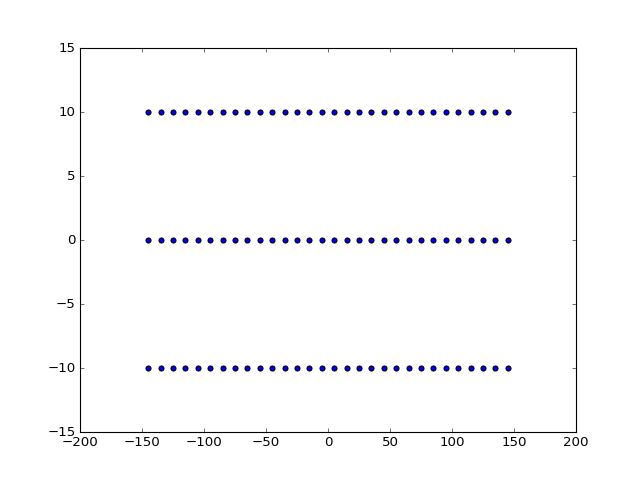

In [19]:
%matplotlib notebook
plt.scatter(locs[:,0],locs[:,1])

In [23]:
rxList = []        
for rx_orientation in ['xx', 'xy', 'yx', 'yy']:
    rxList.append(NSEM.Rx.Point_impedance3D(locs,rx_orientation, 'real'))
    rxList.append(NSEM.Rx.Point_impedance3D(locs,rx_orientation, 'imag'))            
for rx_orientation in ['zx','zy']:
    rxList.append(NSEM.Rx.Point_tipper3D(locs,rx_orientation, 'real'))
    rxList.append(NSEM.Rx.Point_tipper3D(locs,rx_orientation, 'imag'))
# Source list
srcList =[]
for freq in freqs:
    srcList.append(NSEM.Src.Planewave_xy_1Dprimary(rxList,freq))
# Survey MT
survey = NSEM.Survey(srcList)
# Background 1D model
sigma1d = mesh.r(sigma,'CC','CC','M')[0,0,:]
## Setup the problem object
problem = NSEM.Problem3D_ePrimSec(mesh, sigmaMap=simpeg.Maps.IdentityMap(), sigmaPrimary = sigma1d)
problem.verbose = True

problem.Solver = PardisoSolver
problem.pair(survey)

import time
## Calculate the fields
stTime = time.time()
print 'Starting calculating field solution at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
sys.stdout.flush()
FmtSer = problem.fields(sigma)
print 'Ended calculation field at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
print 'Ran for {:f}'.format(time.time()-stTime)

## Project data
stTime = time.time()
print 'Starting projecting fields to data at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
sys.stdout.flush()
mtData = NSEM.Data(survey,survey.eval(FmtSer))
print 'Ended projection of fields at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
print 'Ran for {:f}'.format(time.time()-stTime)

Starting calculating field solution at 2017-01-16 11:14:49
Starting work for 1.000e+01
Ran for 36.431064 seconds
Starting work for 1.778e+01
Ran for 44.458812 seconds
Starting work for 3.162e+01
Ran for 48.295779 seconds
Starting work for 5.623e+01
Ran for 48.850698 seconds
Starting work for 1.000e+02
Ran for 46.882945 seconds
Starting work for 1.778e+02
Ran for 49.178256 seconds
Starting work for 3.162e+02
Ran for 42.226607 seconds
Starting work for 5.623e+02
Ran for 36.312106 seconds
Starting work for 1.000e+03
Ran for 37.462348 seconds
Starting work for 1.778e+03
Ran for 41.219777 seconds
Starting work for 3.162e+03
Ran for 41.877211 seconds
Starting work for 5.623e+03
Ran for 37.092444 seconds
Starting work for 1.000e+04
Ran for 34.634435 seconds
Starting work for 1.778e+04
Ran for 37.303064 seconds
Starting work for 3.162e+04
Ran for 42.235808 seconds
Starting work for 5.623e+04
Ran for 37.774958 seconds
Starting work for 1.000e+05
Ran for 31.330760 seconds
Ended calculation field

In [139]:
# Pickle the data
mtData.survey.unpair()

dill.dump(mtData,open('vertical_contact_mtData_1e2_1e1.pklb','wb'))
dill.dump(FmtSer,open('vertical_contact_Fields.pklb','wb'))

In [25]:
mtData = dill.load(open('vertical_contact_mtData_1e2_1e1.pklb','rb'))
FmtSer = dill.load(open('vertical_contact_Fields.pklb','rb'))

In [99]:
j_px1000.shape

(56840, 3)

<IPython.core.display.Javascript object>


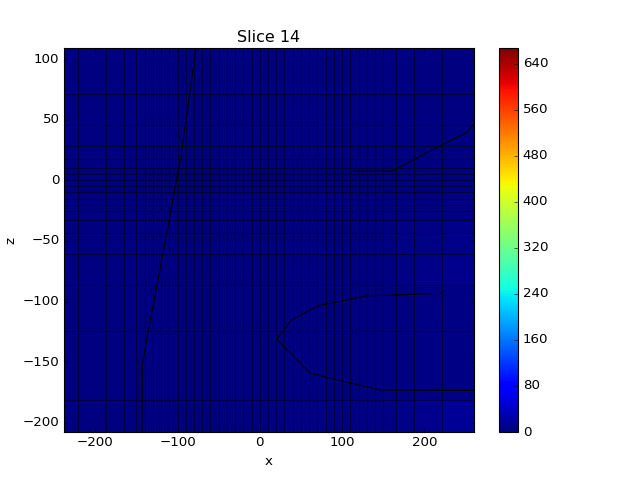

In [138]:
# Calculate the fields and current density
e_t = FmtSer[FmtSer.survey.getSrcByFreq(1000),'e_pxSecondary']
j_t = problem.MeSigma*e_t

fig = plt.figure()

ax = fig.add_axes([.1,.1,.8,.8])
dt = mesh.plotSlice(j_t.real,vType='E',view='vec', normal='Y',ax=ax, grid=True)

# cont2, ax = simpeg.Utils.plot2Ddata(xyz, e_t.real, vec=True,
#                                       ax=ax, contourOpts={"cmap": "viridis"})
# ax.set_xlim(-150,150)
# ax.set_ylim(-150,10)
fig.colorbar(dt[0])

<IPython.core.display.Javascript object>


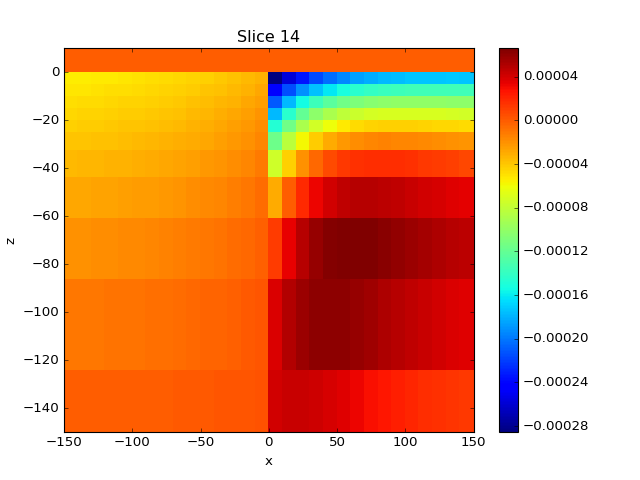

In [89]:
# Calculate the fields and current density
j_t = (mesh.aveE2CC*FmtSer[FmtSer.survey.getSrcByFreq(1000),'e_py']) 
j_py1000 = sigma.reshape(1,-1)*j_t[:,0]

fig = plt.figure()

ax = fig.add_axes([.1,.1,.8,.8])
dt = mesh.plotSlice(j_py1000,normal='Y',ax=ax)
ax.set_xlim(-150,150)
ax.set_ylim(-150,10)
plt.colorbar(dt[0])

In [37]:
FmtSer[FmtSer.survey.getSrcByFreq(1000)]

{'e_pxSolution': array([[  1.31212364e-18 +6.08640760e-18j],
        [ -1.13693816e-19 +2.66600874e-17j],
        [ -5.04411488e-16 -1.96593610e-16j],
        ..., 
        [  3.90930098e-04 -3.74794456e-04j],
        [  1.03883021e-03 -9.99973677e-04j],
        [  1.76758001e-03 -1.70307334e-03j]]),
 'e_pySolution': array([[ -9.25600772e-15 +2.45343097e-15j],
        [ -3.40290054e-14 +9.14542611e-15j],
        [ -7.02290059e-14 +1.95704302e-14j],
        ..., 
        [ -1.72527318e-03 +1.69215274e-03j],
        [ -1.87351510e-03 +1.82566333e-03j],
        [ -1.94308801e-03 +1.88787708e-03j]])}

<IPython.core.display.Javascript object>


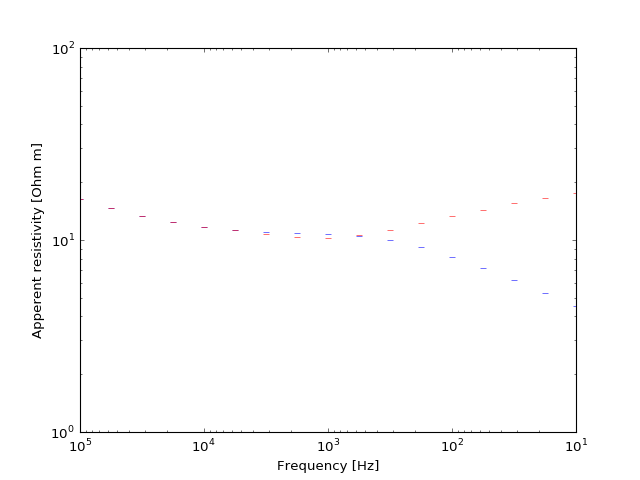

In [34]:
mtData.plot_app_res(np.array([95.,0.]))

<IPython.core.display.Javascript object>


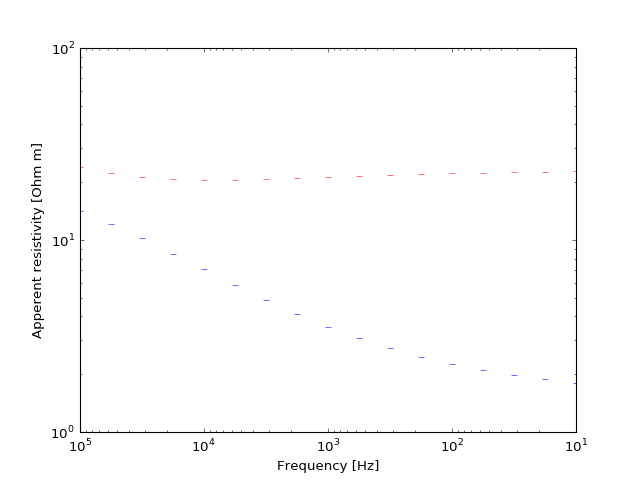

In [29]:
mtData.plot_app_res(np.array([5.,0.]))

<IPython.core.display.Javascript object>


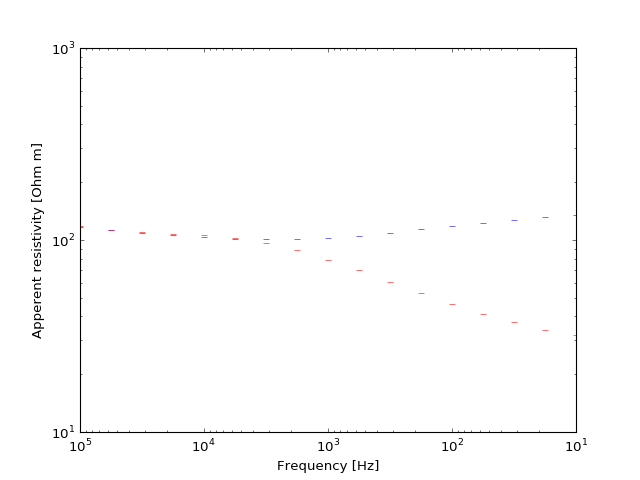

In [35]:
mtData.plot_app_res(np.array([-95.,0.]))

<IPython.core.display.Javascript object>


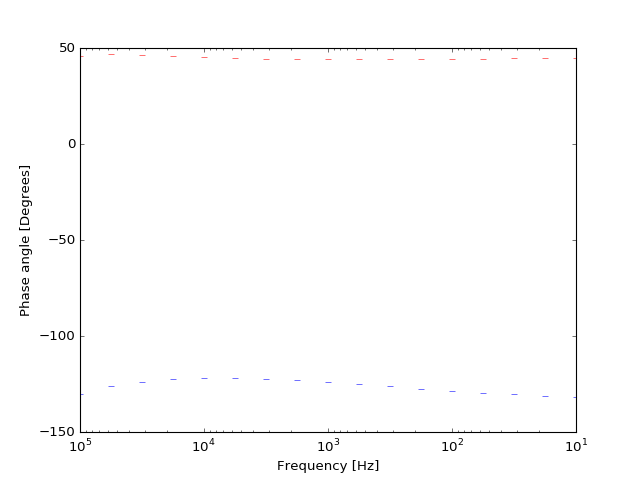

In [30]:
mtData.plot_app_phs(np.array([5.,0.]))